# Create a User Defined Fitter using astropy.modeling

## Authors
Rocio Kiman, Lia Corrales and Zé Vinícius.

## Learning Goals
* Know and understand tools to make user defined fitters with `astropy` and in which cases it could be useful
* Learn custom fitters
* This tutorial assumes the student knows how to fit data using `astropy.modeling`. Check the first tutorial in case you are not familiar with it [here](https://github.com/astropy/astropy-tutorials/tree/master/tutorials/notebooks/Models-Quick-Fit).

## Keywords
Modeling, User Defined Fitter, Custom Fitter 

## Summary
In this tutorial, we will learn how to define a new fitter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.fitting import (_validate_model,
                                      _fitter_to_model_params,
                                      _model_to_fit_params, Fitter,
                                      _convert_input)
from astropy.modeling.optimizers import Simplex
from astropy.modeling import models, fitting
from scipy import optimize

## Basic idea of a Fitter

The objective_function is the error function where we add a measurement to the fit. In this example, the sum of the squared residuals is used as a measure of fitting

In [2]:
class SLSQPFitter(Fitter):
    supported_constraints = ['bounds', 'eqcons', 'ineqcons', 'fixed',
                             'tied']

    def __init__(self):
        # Most currently defined fitters take no arguments in their
        # __init__, but the option certainly exists for custom fitters
        super().__init__()
        
    def objective_function(self, fps, *args):
        model = args[0]
        meas = args[-1]
        model.fitparams(fps)
        res = self.model(*args[1:-1]) - meas
        return np.sum(res**2)
    
    def __call__(self, model, x, y, maxiter=100, epsilon=10**(-12)):
        if model.linear:
                raise ModelLinearityException(
                    'Model is linear in parameters; '
                    'non-linear fitting methods should not be used.')
        model_copy = model.copy()
        init_values, _ = _model_to_fit_params(model_copy)
        self.fitparams = optimize.fmin_slsqp(self.errorfunc, p0=init_values,
                                             args=(y, x),
                                             bounds=self.bounds,
                                             eqcons=self.eqcons,
                                             ineqcons=self.ineqcons)
        return model_copy

In [30]:
from astropy.modeling.optimizers import (SLSQP, Simplex)
from astropy.modeling.statistic import (leastsquare)

class SLSQPFitter(Fitter):
    def __init__(self):
        super().__init__(optimizer=SLSQP, statistic=leastsquare)
                        
    def errorfunc(self, fps, *args):
        meas = args[0]
        self.fitpars = fps
        res = model(*args[1:]) - meas
        return np.sum(res**2)
    
    def __call__(self, model, x, y , maxiter=100, epsilon=10**(-12)):
        b = [model.bounds[key] for key in model.param_names]
        self.fitpars = optimize.fmin_slsqp(self.errorfunc, x0=model.parameters[:],
        args=(y, x), bounds=b)
        #self.objective_function(model.parameters[:],model)
        return self.fitpars

In [25]:
x = np.linspace(0,1,100)
y = 2*x
y_err = np.random.normal(0,0.05,100)
x_err = np.random.normal(0,0.05,100)

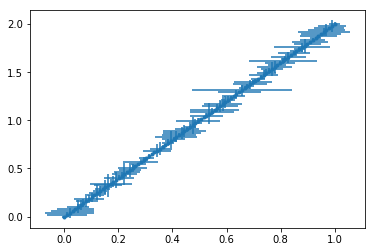

In [26]:
plt.errorbar(x,y,yerr=y_err,xerr=x_err,fmt='.')
plt.show()

In [31]:
model = models.Linear1D()
fitter = SLSQPFitter() 
best_fit2 = fitter(model, x, y)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 33.50168350168351
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1


In [32]:
print(best_fit2)

[1. 0.]


In [33]:
print(model)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    slope intercept
    ----- ---------
      1.0       0.0


TypeError: 'numpy.ndarray' object is not callable

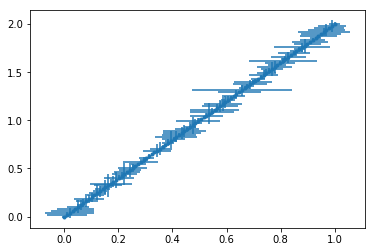

In [29]:
plt.errorbar(x,y,yerr=y_err,xerr=x_err,fmt='.',zorder=0)
plt.plot(x,best_fit2(x),'r',zorder=1)
plt.show()

## Costum Statistic Function

Fit a line with uncertainties in two variables.

In [48]:
def chi_line(measured_vals, updated_model, x_sigma, y_sigma, x):
    """
    Chi^2 statistic for fitting a straight line with uncertainties in x and
    y.

    Parameters
    ----------
    measured_vals : array
    updated_model : `~astropy.modeling.ParametricModel`
        model with parameters set by the current iteration of the optimizer
    x_sigma : array
        uncertainties in x
    y_sigma : array
        uncertainties in y

    """
    model_vals = updated_model(x)
    if x_sigma is None and y_sigma is None:
        return np.sum((model_vals - measured_vals) ** 2)
    elif x_sigma is not None and y_sigma is not None:
        weights = 1 / (y_sigma ** 2 + updated_model.parameters[1] ** 2 *
                       x_sigma ** 2)
        return np.sum((weights * (model_vals - measured_vals)) ** 2)
    else:
        if x_sigma is not None:
            weights = 1 / x_sigma ** 2
        else:
            weights = 1 / y_sigma ** 2
        return np.sum((weights * (model_vals - measured_vals)) ** 2)

In [49]:
class LineFitter(Fitter):
    """
    Fit a straight line with uncertainties in both variables

    Parameters
    ----------
    optimizer : class or callable
        one of the classes in optimizers.py (default: Simplex)
    """

    def __init__(self, optimizer=Simplex):
        self.statistic = chi_line
        super().__init__(optimizer, statistic=self.statistic)

    def __call__(self, model, x, y, x_sigma=None, y_sigma=None, **kwargs):
        """
        Fit data to this model.

        Parameters
        ----------
        model : `~astropy.modeling.core.ParametricModel`
            model to fit to x, y
        x : array
            input coordinates
        y : array
            input coordinates
        x_sigma : array
            uncertainties in x
        y_sigma : array
            uncertainties in y
        kwargs : dict
            optional keyword arguments to be passed to the optimizer

        Returns
        ------
        model_copy : `~astropy.modeling.core.ParametricModel`
            a copy of the input model with parameters set by the fitter

        """
        model_copy = _validate_model(model,
                                     self._opt_method.supported_constraints)

        farg = _convert_input(x, y)
        farg = (model_copy, x_sigma, y_sigma) + farg
        p0, _ = _model_to_fit_params(model_copy)

        fitparams, self.fit_info = self._opt_method(
            self.objective_function, p0, farg, **kwargs)
        _fitter_to_model_params(model_copy, fitparams)

        return model_copy

Compare goodness of fit with this new fitter and one with only errors in y.

In [50]:
model = models.Linear1D()
fitter = LineFitter() 
best_fit = fitter(model, x, y, x_sigma = x_err, y_sigma=y_err)

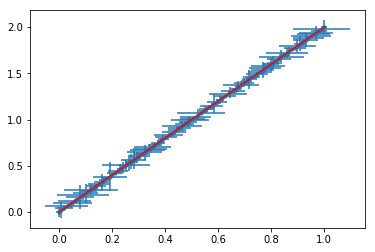

In [57]:
plt.errorbar(x,y,yerr=y_err,xerr=x_err,fmt='.',zorder=0)
plt.plot(x,best_fit(x),'r',zorder=1)
plt.show()